# VAE Attempt

In [1]:
import os
import matplotlib.image as pltim
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling

2023-03-10 00:36:13.818490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 00:36:13.933596: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-10 00:36:14.470274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-10 00:36:14.470341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# Params

BATCH_SIZE = 32
INPUT_SHAPE = (448, 448, 3)
EPOCHS = 500
LATENT_DIM = 500

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

In [4]:
X_train = image_dataset_from_directory(
    '../raw_data/abstract_art_512/', 
    labels=None, # Changed from label_mode -> labels
    image_size=INPUT_SHAPE[:2], 
    batch_size=BATCH_SIZE,
    crop_to_aspect_ratio=True,
)

Found 8145 files belonging to 1 classes.


2023-03-10 00:36:15.694160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 00:36:15.730060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 00:36:15.730296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 00:36:15.730693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
##ds = ds.map(lambda x: x/255)
##ds = ds.map(lambda x: (x, x))

In [6]:
im = Image.open('../raw_data/abstract_art_512/abstract_abdul-qader-al-raes_258.jpg')
im.mode

'RGB'

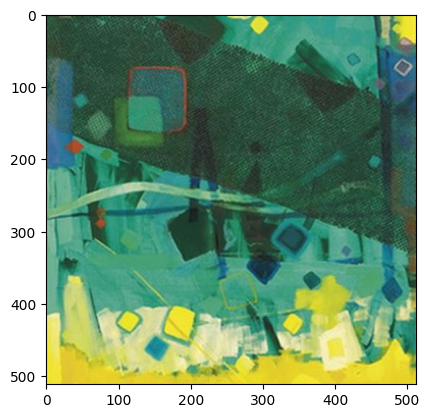

In [7]:
im = pltim.imread('../raw_data/abstract_art_512/abstract_abdul-qader-al-raes_258.jpg')
plt.imshow(im)

In [8]:
imgs = X_train.as_numpy_iterator().__next__()

In [9]:
imgs.shape

(32, 448, 448, 3)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU

X_train=imgs/255

def build_encoder(latent_dimension):
    encoder = Sequential()
    
    encoder.add(Rescaling(scale=1./255, input_shape=(448, 448, 3))) # Added this layer
    encoder.add(Conv2D(32, (3, 3), padding='same', activation='relu')) #, input_shape=(448, 448, 3)))
    # encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    # encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    # encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))
    
    encoder.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU()))
    # encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))
    
    return encoder

In [11]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
def build_decoder(latent_dimension):
    decoder = Sequential()
    decoder.add(Dense(7*7*64, activation='tanh', input_shape=(latent_dimension,)))
    decoder.add(Reshape((7, 7, 64)))
    decoder.add(Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'))
    #decoder.add(UpSampling2D((2, 2)))
    decoder.add(Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid'))
    return decoder

In [12]:
encoder = build_encoder(latent_dimension=LATENT_DIM)

In [13]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 448, 448, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 448, 448, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     7

In [14]:
decoder = build_decoder(latent_dimension=LATENT_DIM)

In [15]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3136)              1571136   
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      73856     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 56, 56, 32)       18464     
 ranspose)                                                       
                                                      

In [16]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
def build_autoencoder(encoder, decoder):
    inp = Input(INPUT_SHAPE)
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

autoencoder = build_autoencoder(encoder, decoder)

In [17]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='mse', optimizer='adam')

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

compile_autoencoder(autoencoder)

In [93]:
autoencoder.fit(
    X_train, X_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=[es], 
    verbose=1
)

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.0123
Epoch 2/500
1/1 [==============================] - 0s 374ms/step - loss: 0.0124
Epoch 3/500
1/1 [==============================] - 0s 371ms/step - loss: 0.0124
Epoch 4/500
1/1 [==============================] - 1s 662ms/step - loss: 0.0123
Epoch 5/500
1/1 [==============================] - 1s 657ms/step - loss: 0.0123
Epoch 6/500
1/1 [==============================] - 1s 657ms/step - loss: 0.0122
Epoch 7/500
1/1 [==============================] - 1s 681ms/step - loss: 0.0121
Epoch 8/500
1/1 [==============================] - 1s 711ms/step - loss: 0.0120
Epoch 9/500
1/1 [==============================] - 1s 668ms/step - loss: 0.0120
Epoch 10/500
1/1 [==============================] - 0s 373ms/step - loss: 0.0120
Epoch 11/500
1/1 [==============================] - 0s 382ms/step - loss: 0.0121
Epoch 12/500
1/1 [==============================] - 0s 381ms/step - loss: 0.0121
Epoch 13/500
1/1 [======================

In [94]:
prediction = autoencoder.predict(X_train, verbose=0, batch_size=32)# you can now display an image to see it is reconstructed well

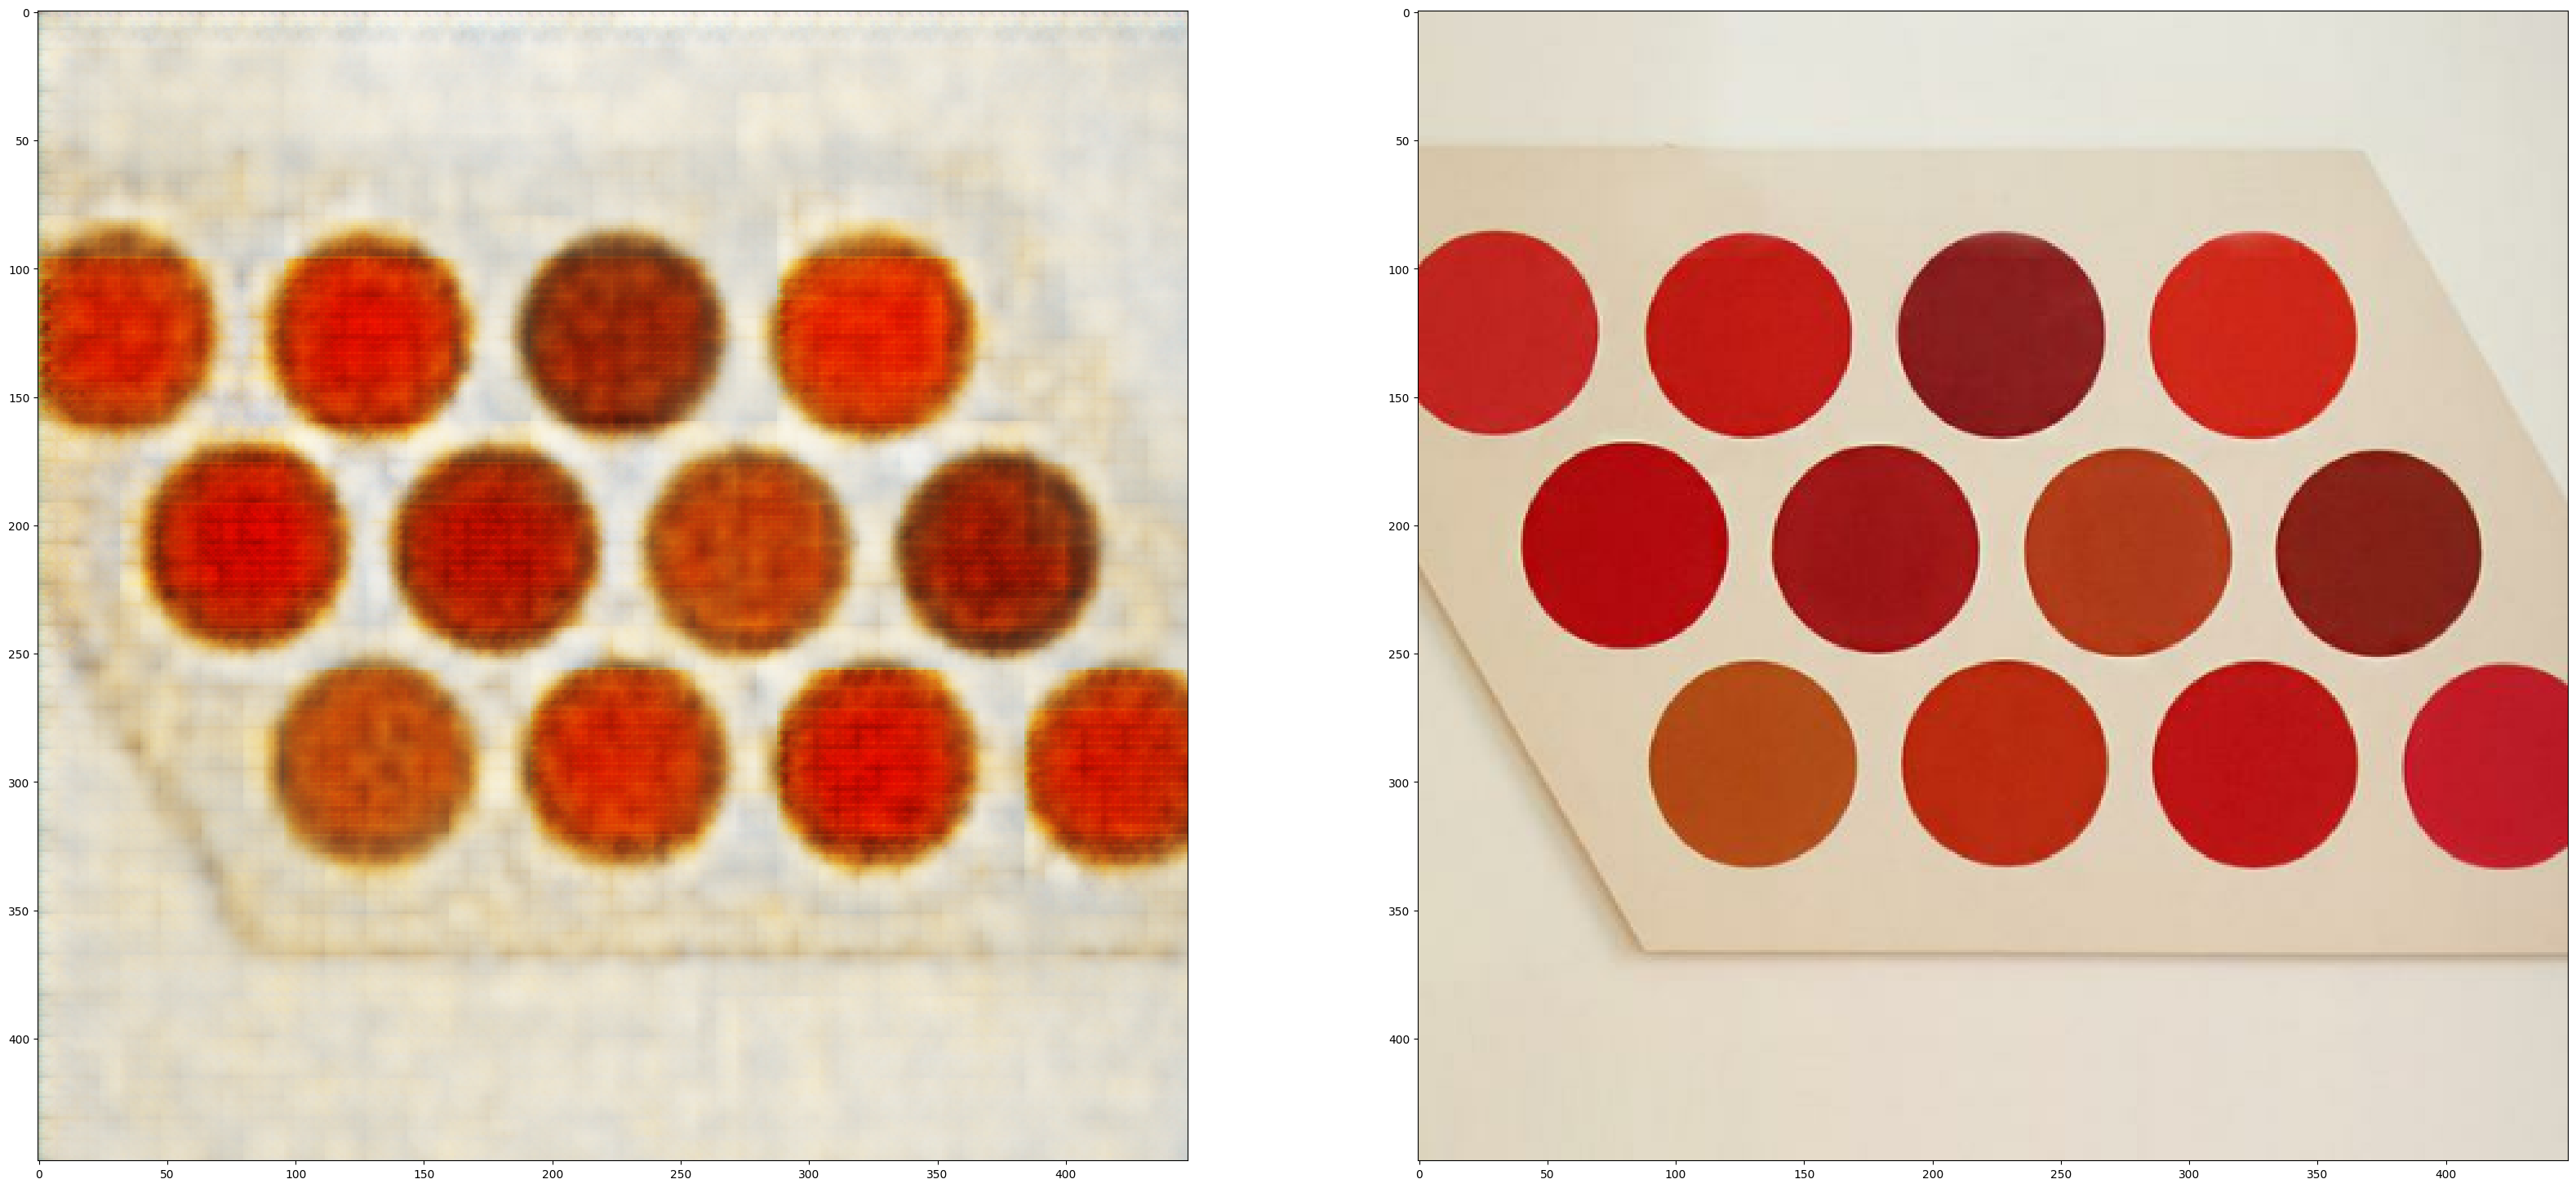

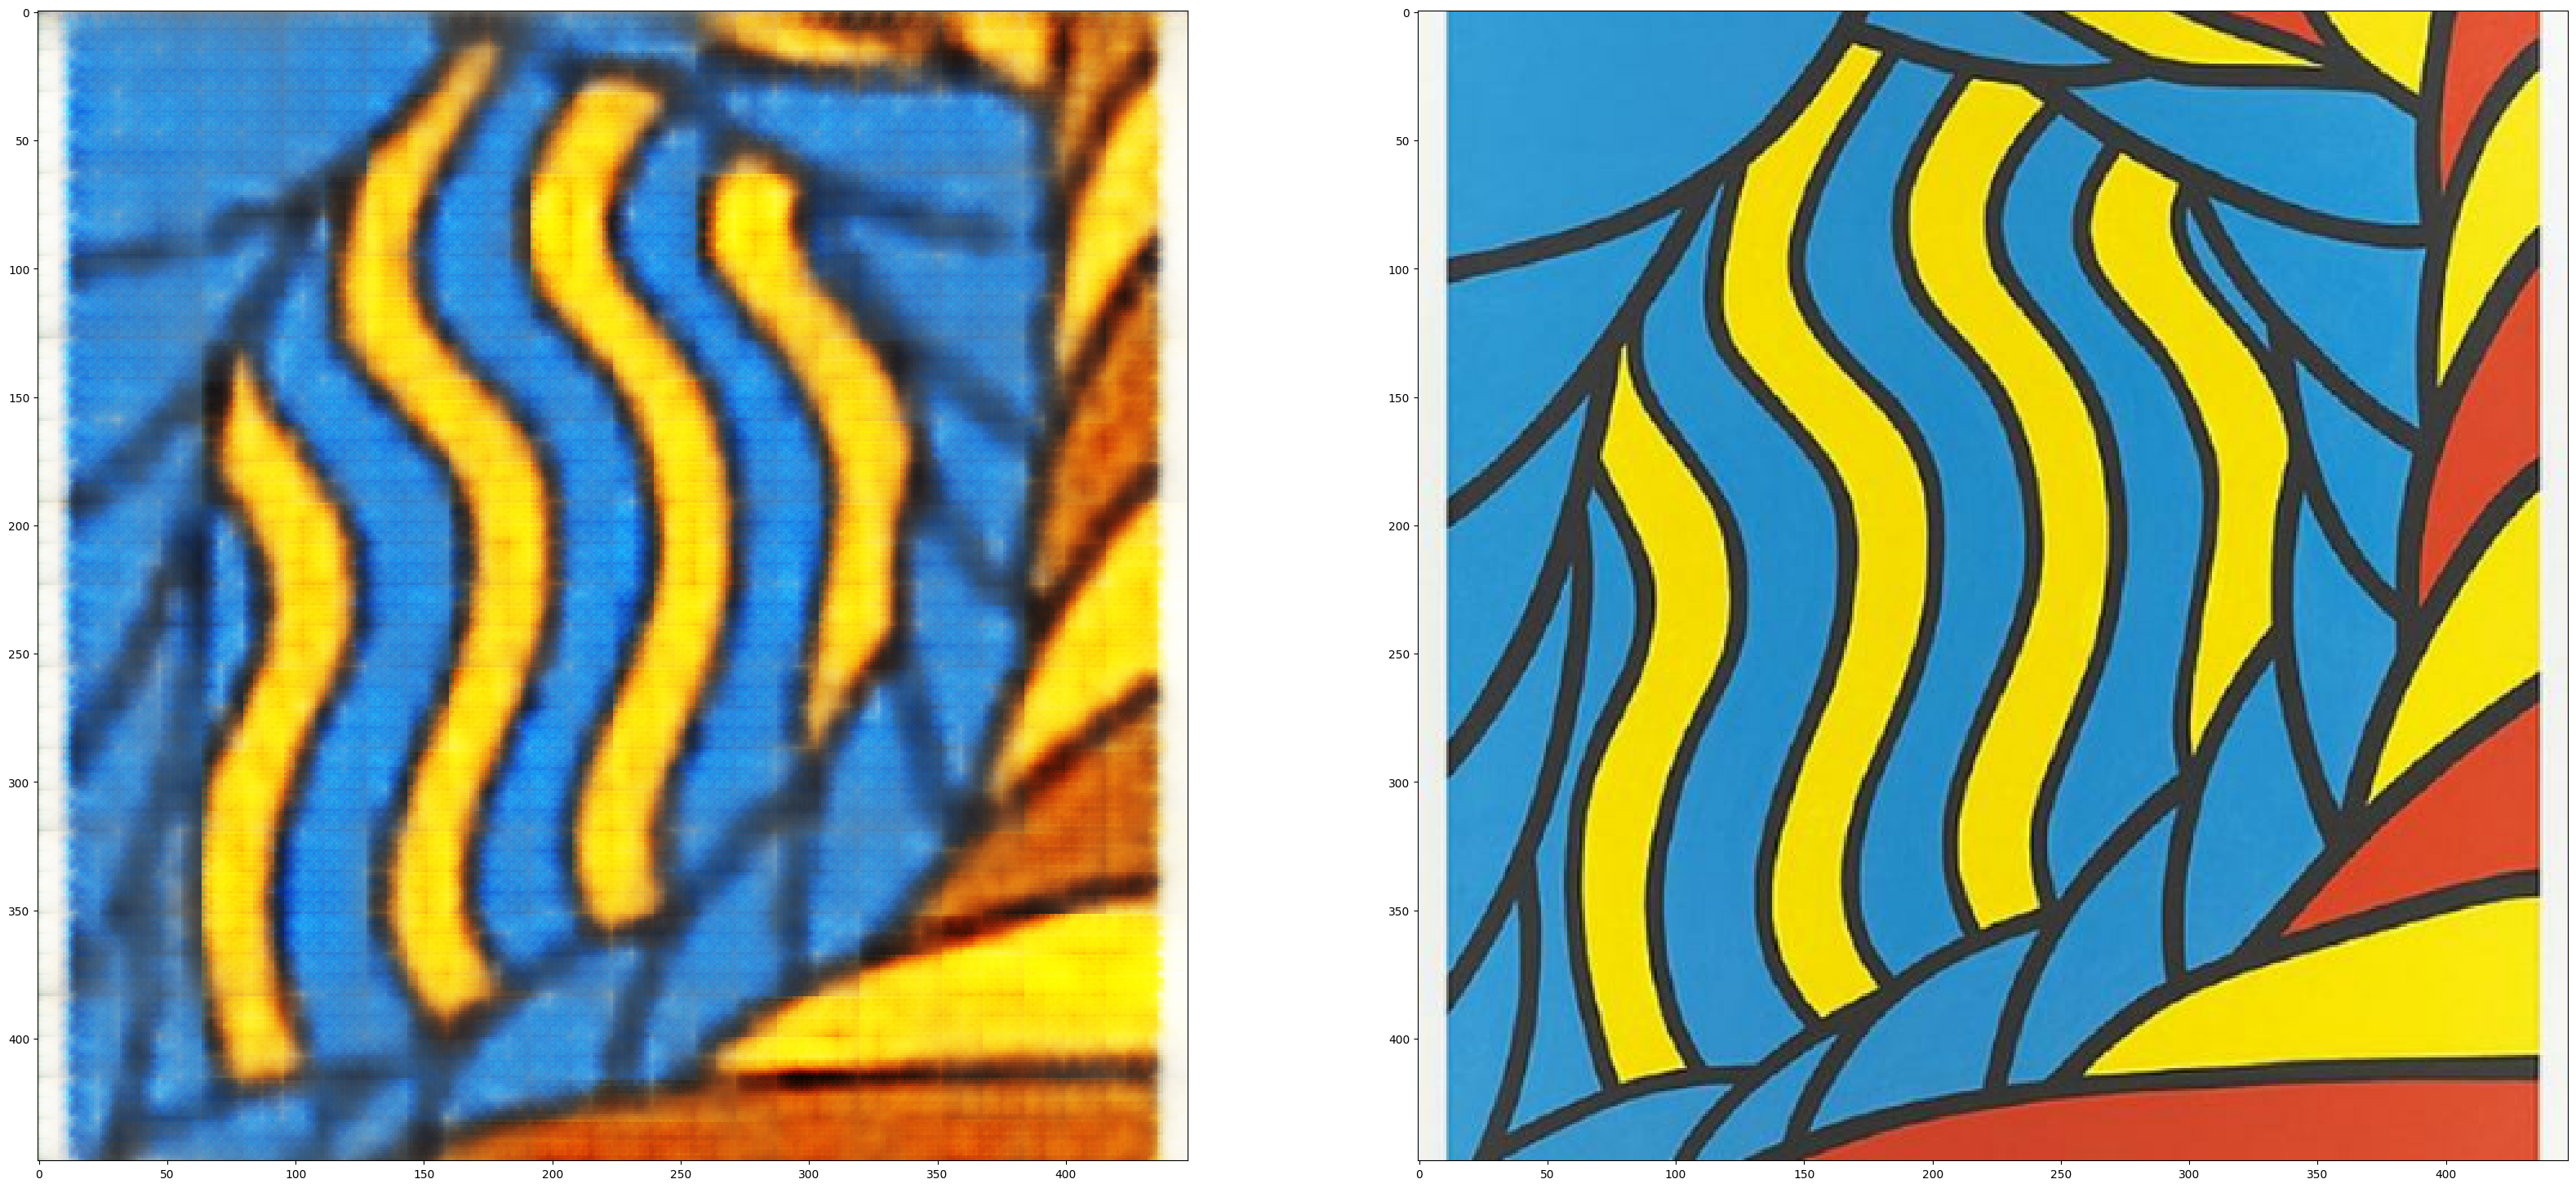

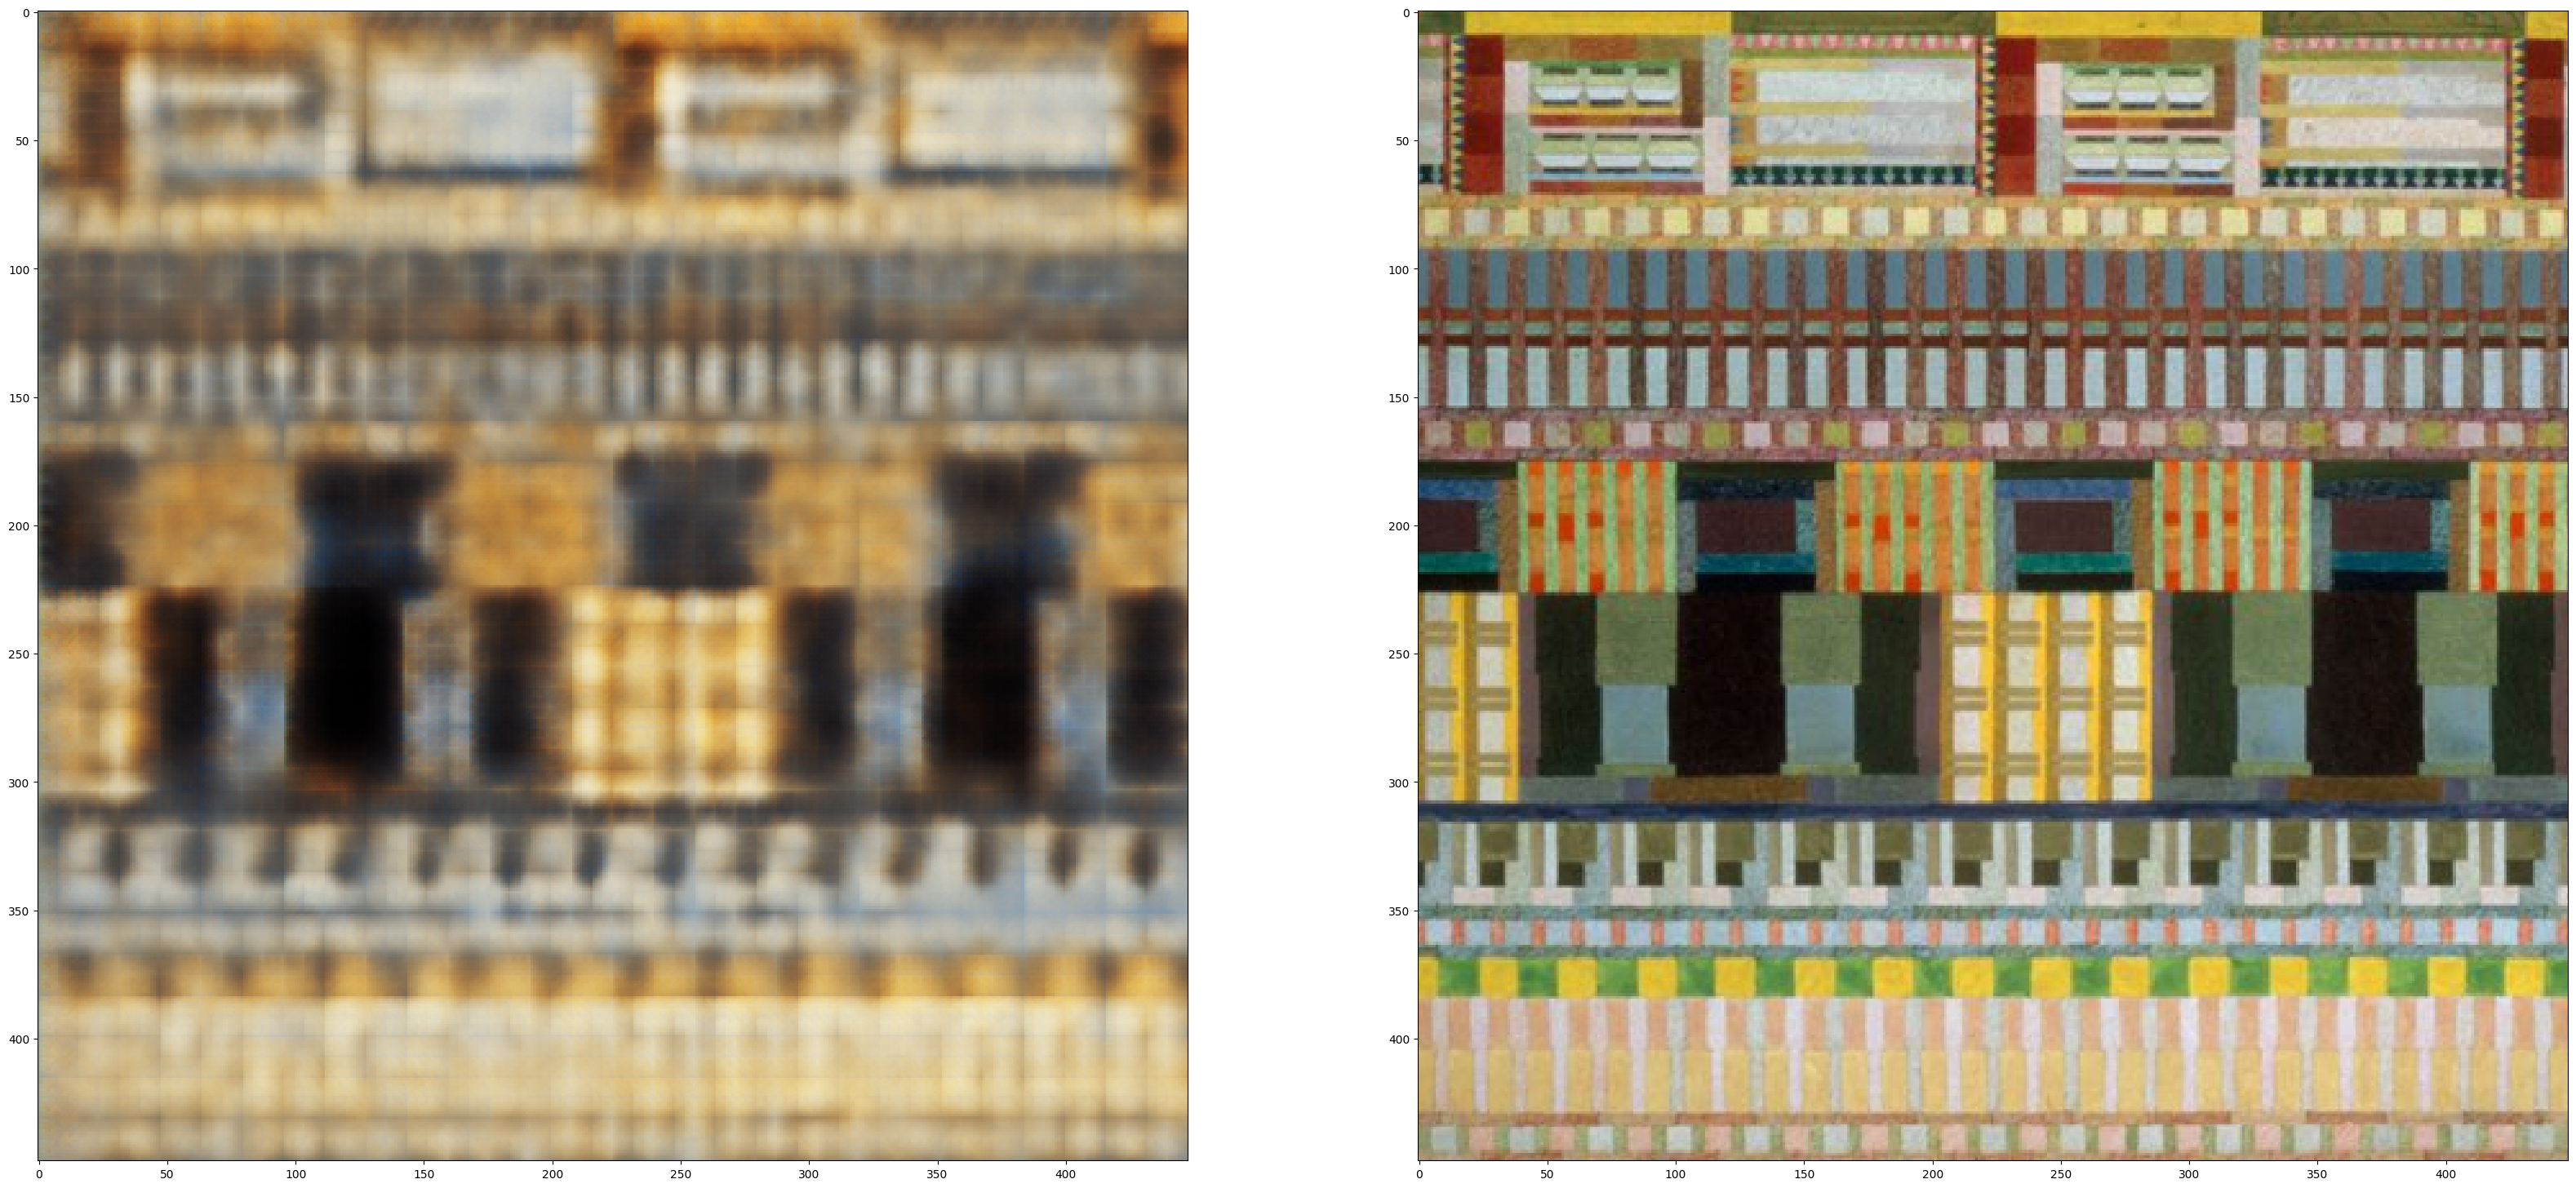

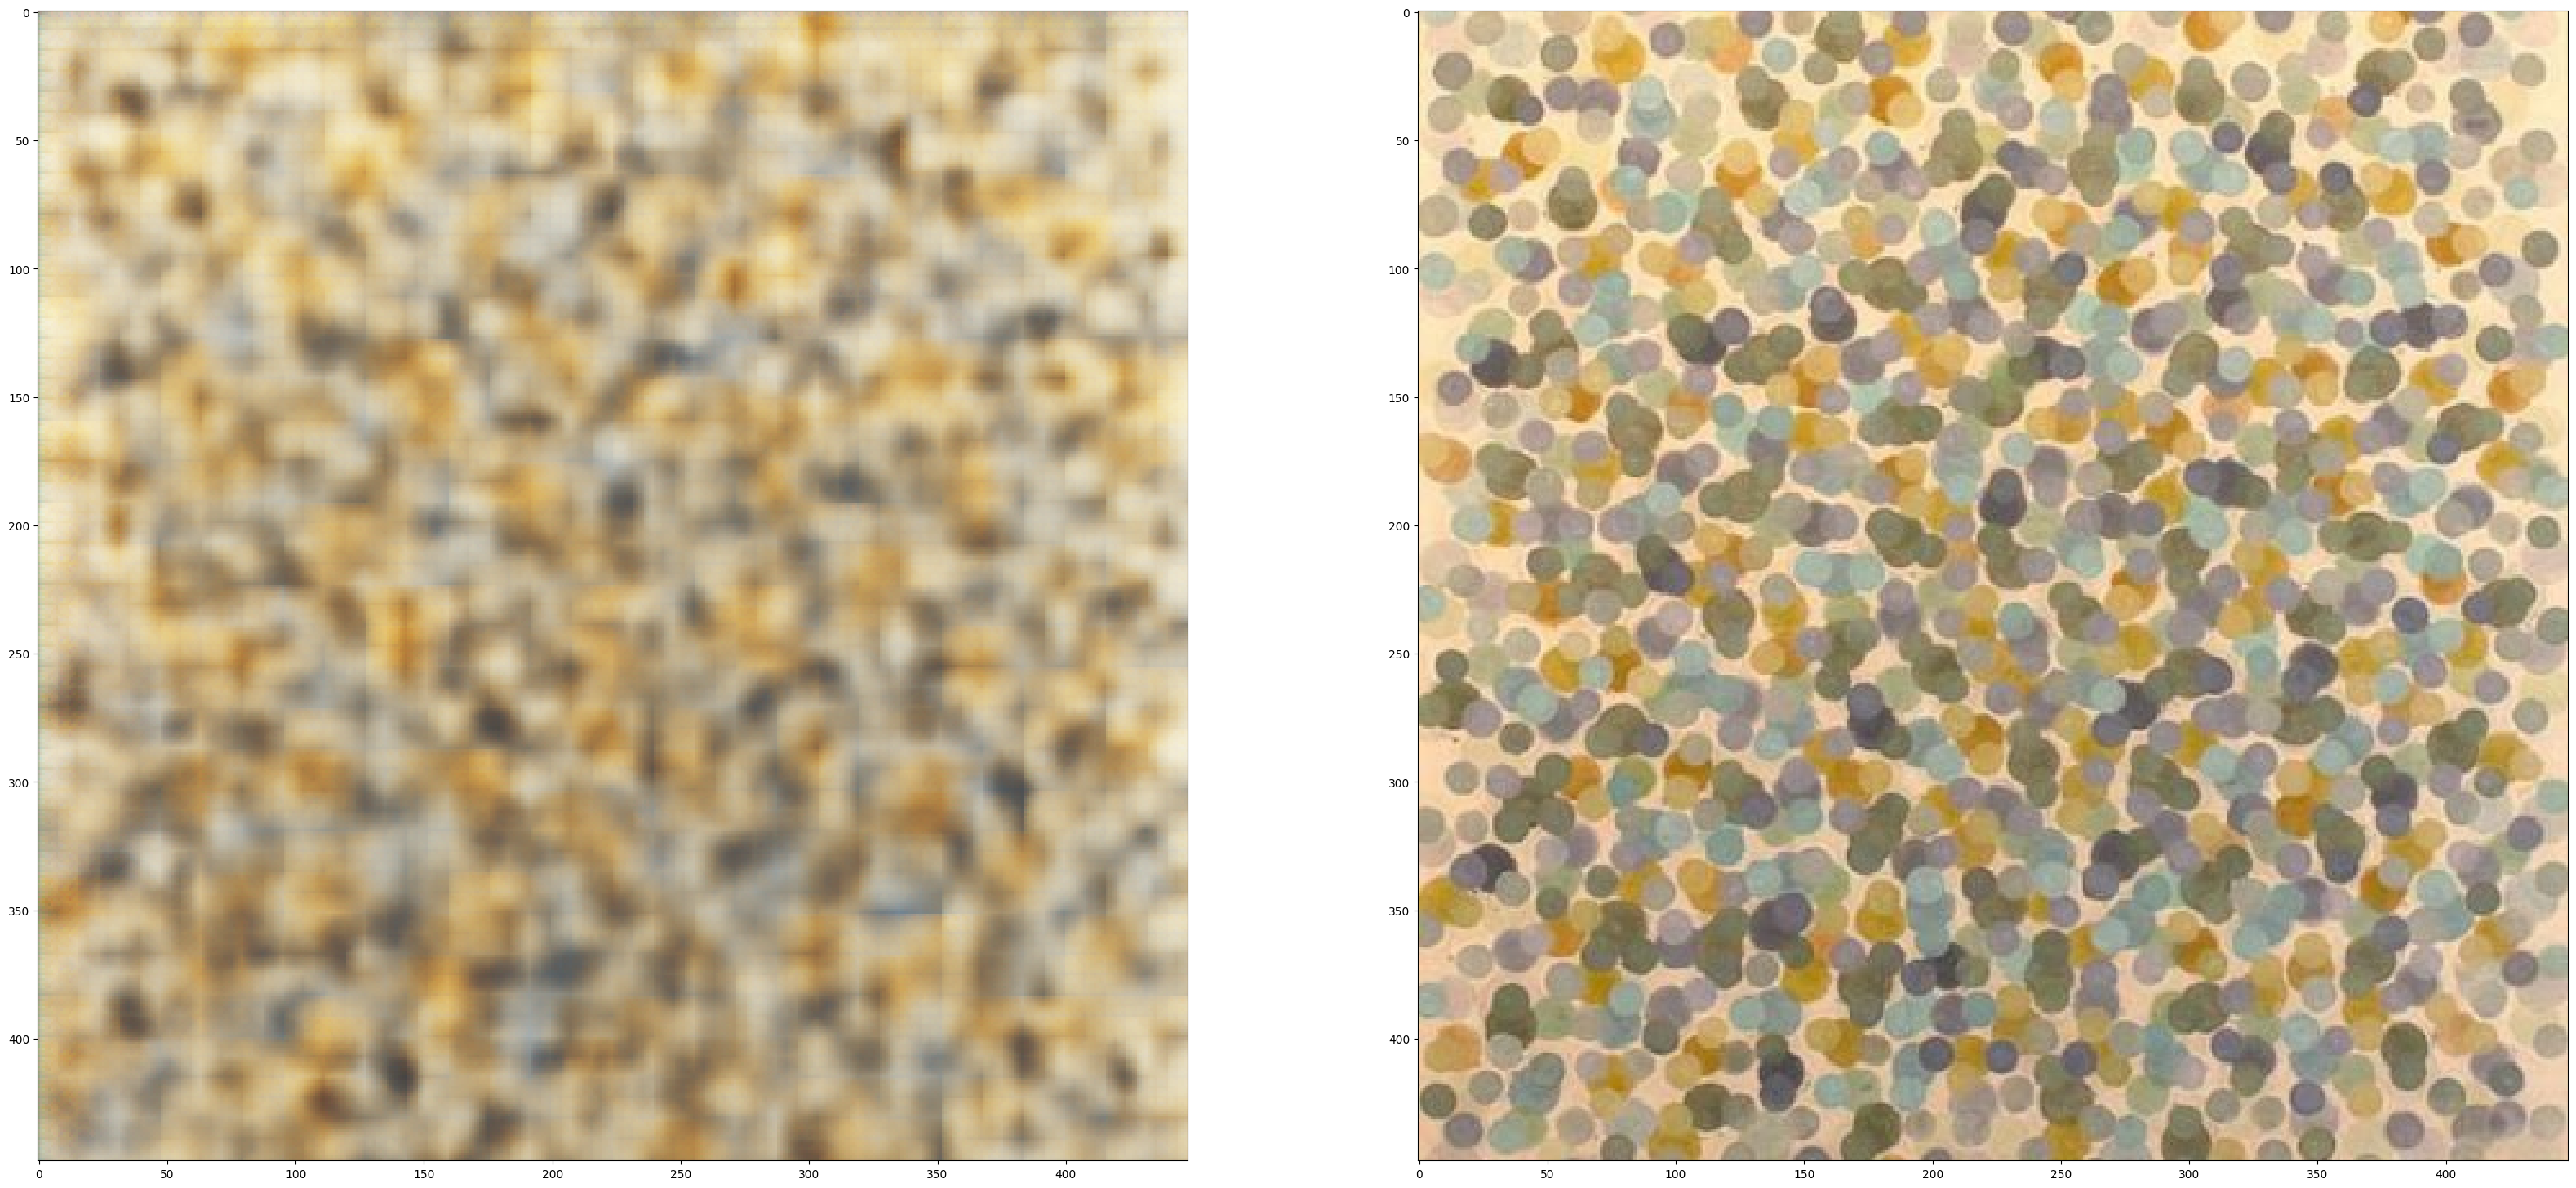

In [96]:
for i in range(3, 7):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((prediction[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(448, 448, 3))
    plt.show()

In [108]:
autoencoder.save('../saved_models/autoencoder-latent-dim-500-e500.h5')

# Creating interpolated images

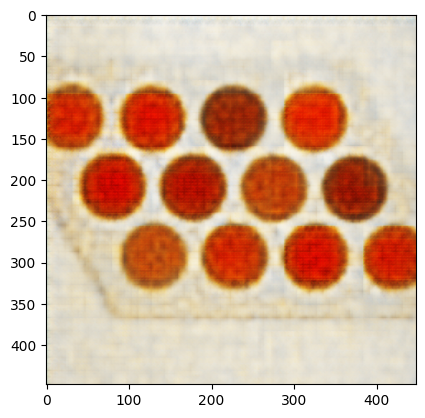

In [98]:
plt.imshow(prediction[3])

# Creating new images

In [99]:
# The latent space vectors for the first two images

encoded_pred = encoder.predict(X_train[3:5])

1/1 [==============================] - 0s 20ms/step


In [100]:
encoded_pred.shape

start_lat_vec, end_lat_vec = encoded_pred[0], encoded_pred[1]

In [101]:
# Take 100 even spaced steps in a direct line between the two images. 

N_STEPS = 100

In [102]:
# The step size is (end point minus start point) / N_STEPS

step_vec = (end_lat_vec - start_lat_vec ) / N_STEPS

In [103]:
interpolation_images = []

for i in range(0, N_STEPS + 1):
    interpolation_images.append(start_lat_vec + (i * step_vec))
    
interp_array = np.array(interpolation_images)

In [104]:
# Do a .predict on the decoder with the interpolated vectors from latent space

inter_images = decoder.predict(interp_array)
inter_images = (inter_images * 255).astype('uint8')

4/4 [==============================] - 0s 50ms/step


In [105]:
for i in range(inter_images.shape[0]):
    im = Image.fromarray(inter_images[i])
    im.save(f'../raw_data/abstract_art_test2/image_{i}.jpg')

# Save as .gif

In [5]:
from PIL import Image

In [6]:
def make_gif(frame_folder):
    im_paths = [f'{frame_folder}/image_{i}.jpg' for i in range(100)]
    frames = [Image.open(image) for image in im_paths]
    
    frame_one = frames[0]
    frame_one.save(
        'abstract_art_test2.gif', 
        format='GIF', 
        append_images=frames, 
        save_all=True,
        duration=100,
        loop=0
    )

In [8]:
make_gif('../raw_data/abstract_art_test')